# *Gromacs_py* basic example

Here is an example of a short simulation of the SH3 domain of phospholipase Cγ1.
Five successive steps are used:

1. Topologie creation using ``GmxSys.prepare_top()``.
2. Minimisation of the structure using ``GmxSys.em_2_steps()``.
3. Solvation of the system using ``GmxSys.solvate_add_ions()``.
4. Equilibration of the system using ``GmxSys.em_equi_three_step_iter_error()``.
5. Production run using ``GmxSys.production()``.


### Import

In [36]:
import sys
import os
import urllib.request  
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Gromacs_py import
sys.path.insert(0, os.path.abspath('../../..'))
import gromacs_py.gromacs.gmx5 as gmx

## Simulation setup

In [37]:
# Setup data location
DATA_OUT = 'data_sim'
PDB_ID = '1Y0M'

# System Setup
vsite='hydrogens'
ion_C = 0.15
sys_top_folder = os.path.join(DATA_OUT, 'sys_top')

# Energy Minimisation
em_folder = os.path.join(DATA_OUT, 'em')
em_sys_folder = os.path.join(DATA_OUT, 'sys_em')
em_step_number = 5000

# Equillibration
equi_folder = os.path.join(DATA_OUT, 'sys_equi')
HA_time = 0.5
CA_time = 1.0
CA_LOW_time = 2.0

dt_HA = 0.002
dt = 0.005

HA_step = 1000 * HA_time / dt_HA
CA_step = 1000 * CA_time / dt
CA_LOW_step = 1000 * CA_LOW_time / dt

## Get PDB file from the ``rcsb.org`` website 

In [38]:
os.makedirs(DATA_OUT, exist_ok = True)

raw_pdb = urllib.request.urlretrieve('http://files.rcsb.org/download/{}.pdb'.format(PDB_ID),
                           '{}/{}.pdb'.format(DATA_OUT, PDB_ID))

### Define the simulation system

In [39]:
md_sys = gmx.GmxSys(name=PDB_ID, coor_file=raw_pdb[0])
md_sys.display()


name         : 1Y0M
coor_file    : data_sim/1Y0M.pdb
nt           : 0
ntmpi        : 0
sys_history  : 0


## 1. Create topologie:

In [40]:
md_sys.prepare_top(out_folder=os.path.join(DATA_OUT, 'prot_top'), vsite=vsite)
md_sys.create_box(dist=1.0, box_type="dodecahedron", check_file_out=True)

Succeed to read file ../1Y0M.pdb ,  648 atoms found
Succeed to save file tmp_pdb2pqr.pdb
pdb2pqr.py --ff CHARMM --ffout CHARMM --chain tmp_pdb2pqr.pdb 00_1Y0M.pqr
Succeed to read file 00_1Y0M.pqr ,  996 atoms found
Chain: A  Residue: 0 to 60
Succeed to save file 01_1Y0M_good_his.pdb
-Create topologie
gmx pdb2gmx -f 01_1Y0M_good_his.pdb -o 1Y0M_pdb2gmx.pdb -p 1Y0M_pdb2gmx.top -i 1Y0M_posre.itp -water tip3p -ff charmm36-jul2017 -ignh -vsite hydrogens
Molecule topologie present in 1Y0M_pdb2gmx.top , extract the topologie in a separate file: 1Y0M_pdb2gmx.itp
Protein_chain_A
-ITP file: 1Y0M_pdb2gmx.itp
-molecules defined in the itp file:
* Protein_chain_A
Rewrite topologie: 1Y0M_pdb2gmx.top
-Create pbc box
gmx editconf -f data_sim/prot_top/1Y0M_pdb2gmx.pdb -o data_sim/prot_top/1Y0M_pdb2gmx_box.pdb -bt dodecahedron -d 1.0


## 2. Energy minimisation

In [8]:
md_sys.em_2_steps(out_folder=em_folder,
                  no_constr_nsteps=em_step_number,
                  constr_nsteps=em_step_number,
                  posres="",
                  create_box_flag=False)

Mdp files not created,  Init_em_1Y0M.mdp already exist
-Create the tpr file  Init_em_1Y0M.tpr
create_tpr not launched Init_em_1Y0M.tpr already exist
-Launch the simulation Init_em_1Y0M.tpr
Simulation not launched Init_em_1Y0M.gro already exist
Mdp files not created,  1Y0M.mdp already exist
-Create the tpr file  1Y0M.tpr
create_tpr not launched 1Y0M.tpr already exist
-Launch the simulation 1Y0M.tpr
Simulation not launched 1Y0M.gro already exist


## Plot energy:

-Extract energy
gmx energy -f data_sim/em/Init_em_1Y0M.edr -o tmp.xvg
-Extract energy
gmx energy -f data_sim/em/1Y0M.edr -o tmp.xvg


Text(0, 0.5, 'energy (KJ/mol)')

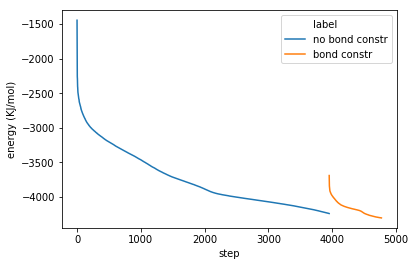

In [9]:
ener_pd_1 = md_sys.sys_history[-1].get_ener(selection_list=['Potential'])
ener_pd_2 = md_sys.get_ener(selection_list=['Potential'])

ener_pd_1['label'] = 'no bond constr'
ener_pd_2['label'] = 'bond constr'

ener_pd = pd.concat([ener_pd_1, ener_pd_2])

ener_pd.time = np.arange(len(ener_pd))

#ax = ener_pd.plot(x='time')
ax = sns.lineplot(x="time", y="Potential",
             hue="label",
             data=ener_pd)
ax.set_xlabel('step')
ax.set_ylabel('energy (KJ/mol)')

## 3. Solvation (water and $Na^{+} Cl^{-}$)

In [10]:
md_sys.solvate_add_ions(out_folder=sys_top_folder,
                        ion_C=ion_C)
md_sys.display()


-Create pbc box
create_box not launched data_sim/em/1Y0M_box.pdb already exist
-Solvate the pbc box
solvate_box not launched 1Y0M_water.pdb already exist
add ions not launched 1Y0M_water_ion.gro already exist
name         : 1Y0M
sim_name     : 1Y0M
coor_file    : data_sim/sys_top/1Y0M_water_ion.gro
top_file     : data_sim/sys_top/1Y0M_water_ion.top
tpr          : data_sim/em/1Y0M.tpr
mdp          : data_sim/em/1Y0M.mdp
xtc          : data_sim/em/1Y0M.trr
edr          : data_sim/em/1Y0M.edr
log          : data_sim/em/1Y0M.log
nt           : 0
ntmpi        : 0
sys_history  : 2


## 4. System minimisation and equilibration

In [11]:
md_sys.em_equi_three_step_iter_error(out_folder=equi_folder,
                                     no_constr_nsteps=em_step_number,
                                     constr_nsteps=em_step_number,
                                     nsteps_HA=HA_step,
                                     nsteps_CA=CA_step,
                                     nsteps_CA_LOW=CA_LOW_step,
                                     dt=dt, dt_HA=dt_HA)


Mdp files not created,  Init_em_1Y0M.mdp already exist
-Create the tpr file  Init_em_1Y0M.tpr
create_tpr not launched Init_em_1Y0M.tpr already exist
-Launch the simulation Init_em_1Y0M.tpr
Simulation not launched Init_em_1Y0M.gro already exist
Mdp files not created,  1Y0M.mdp already exist
-Create the tpr file  1Y0M.tpr
create_tpr not launched 1Y0M.tpr already exist
-Launch the simulation 1Y0M.tpr
Simulation not launched 1Y0M.gro already exist
-Convert trj/coor
convert trj not launched data_sim/sys_equi/sys_em/1Y0M_compact.pdb already exist
Mdp files not created,  equi_HA_1Y0M.mdp already exist
-Create the tpr file  equi_HA_1Y0M.tpr
create_tpr not launched equi_HA_1Y0M.tpr already exist
-Launch the simulation equi_HA_1Y0M.tpr
Simulation not launched equi_HA_1Y0M.gro already exist
Mdp files not created,  equi_CA_1Y0M.mdp already exist
-Create the tpr file  equi_CA_1Y0M.tpr
create_tpr not launched equi_CA_1Y0M.tpr already exist
-Launch the simulation equi_CA_1Y0M.tpr
gmx mdrun -s equi_CA

KeyboardInterrupt: 

-Extract energy
gmx energy -f ../01_equi_CA/equi_CA_1Y0M.edr -o tmp.xvg


Text(0, 0.5, 'energy (KJ/mol)')

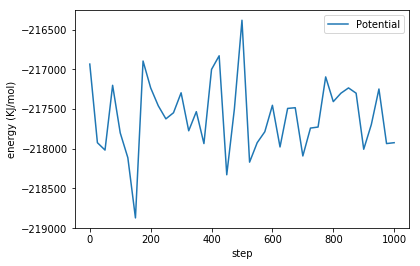

In [12]:
ener_pd = md_sys.sys_history[-1].get_ener(selection_list=['Potential'])
ax = ener_pd.plot(x='time')
ax.set_xlabel('step')
ax.set_ylabel('energy (KJ/mol)')

In [41]:
md_sys.display_history()

In [33]:
ener_pd_1 = md_sys.sys_history[-2].get_ener(selection_list=['Temp'])
ener_pd_2 = md_sys.sys_history[-1].get_ener(selection_list=['Temp'])
ener_pd_3 = md_sys.get_ener(selection_list=['Temp'])

ener_pd_1['label'] = 'HA_constr'
ener_pd_2['label'] = 'CA_constr'
ener_pd_2.time = ener_pd_2.time + ener_pd_1.time.max()
ener_pd_3['label'] = 'CA_LOW_constr'
ener_pd_3.time = ener_pd_3.time + ener_pd_2.time.max()

ener_pd = pd.concat([ener_pd_1, ener_pd_2, ener_pd_3])



-Extract energy
gmx energy -f ../00_equi_HA/equi_HA_1Y0M.edr -o tmp.xvg
-Extract energy
gmx energy -f ../01_equi_CA/equi_CA_1Y0M.edr -o tmp.xvg
-Extract energy
gmx energy -f ../01_equi_CA/equi_CA_1Y0M.edr -o tmp.xvg


(305, 322)

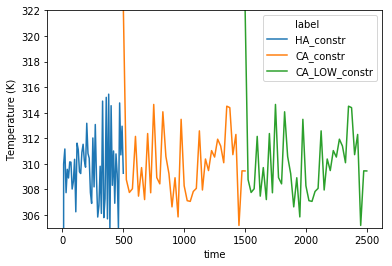

In [35]:
ax = sns.lineplot(x="time", y="Temperature",
                  hue="label",
                  data=ener_pd)

ax.set_xlabel('time')
ax.set_ylabel('Temperature (K)')
ax.set_ylim(305, 322)

## 5. Production

In [ ]:
len(ener_pd_1)